In [60]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import re
import cv2
from pathlib import Path

# Define method

In [61]:
def is_japanese(string):
    for chr in string:
        try:
            name = unicodedata.name(ch)
            if "CJK UNIFIED" in name or "HIRAGANA" in name or "KATAKANA" in name:
                return true
            
        except:
            continue
    
    return False

def RMSLE(x : np.ndarray, y : np.ndarray):
    x_log = np.log(x + 1)
    y_log = np.log(y + 1)
    mse = ((x_log - y_log)**2).sum() / len(y)
    rmsle = np.sqrt(mse)
    
    return rmsle

def new_category(x):
    if x in [1, 30, 43, 44, 10, 20, 24]:
        return 1
    elif x in [26, 27, 28]:
        return 2
    else:
        return x

def relate_category(x):
    if x in [30, 43, 44]:
        return 0
    else:
        return 1

def judge_channel_over_100(x):
    if x in ["ANNnewsCH", "Khan Academy", "Khan Academy", "TED", "UNIVERSAL MUSIC JAPAN", "avex"]:
        return x
    else:
        return "others"
    
def is_insta_in_description(x):
    x = x.lower()
    is_insta = (bool(re.search("insta", x)) or bool(re.search("インスタ", x)))
    return is_insta

def is_twitter_in_description(x):
    x = x.lower()
    is_twitter = (bool(re.search("twitter", x)) or bool(re.search("ツイッター", x)))
    return is_twitter

def is_facebook_in_description(x):
    x = x.lower()
    is_facebook = (bool(re.search("facebook", x)) or bool(re.search("フェイスブック", x)))
    return is_facebook

# Preprocessing 

In [62]:
def fillNan(df):
    df["tags"].fillna("[none]", inplace=True)
    df["description"].fillna(" ", inplace=True)
    df["title"].fillna(" ", inplace=True)
    
    return df

def boolToInt(df):
    df["comments_disabled"] = df["comments_disabled"].astype(np.int16)
    df["ratings_disabled"] = df["ratings_disabled"].astype(np.int16)
    
    return df

def logarize(df):
    df["log_likes"] = np.log(df["likes"] + 1)
    df["log_dislikes"] = np.log(df["dislikes"] + 1)
    df["log_comment_count"] = np.log(df["comment_count"] + 1)
    
    return df

def likes_dislikes_ratio(df):
    df["likes_dislikes_ratio"] = df["likes"] / (df["dislikes"] + 1)
    return df

def comments_likes_ratio(df):
    df["comments_likes_ratio"] = df["comment_count"] / (df["likes"] + 1)
    return df

def comments_dislikes_ratio(df):
    df["comments_dislikes_ratio"] = df["comment_count"] / (df["dislikes"] + 1)
    return df

def likes_comments_disabled(df):
    df["likes_comments_disabled"] = np.log(df["likes"] * df["comments_disabled"] + 1)
    return df

def dislikes_commentes_diabled(df):
    df["dislikes_comments_disabled"] = np.log(df["likes"] * df["comments_disabled"] + 1)
    return df

def comments_ratings_diabled(df):
    df["comments_ratings_diabled"] = np.log(df["comment_count"] * df["ratings_disabled"] + 1)
    return df

def getTagDetail(df):
    df["num_tags"] = df["tags"].astype(str).apply(lambda x : len(x.split("|")))
    df["length_tags"] = df["tags"].astype(str).apply(lambda x : len(x))
    df["tags_point"] = df["tags"].apply(lambda x : sum([bool(re.search("[a-zA-Z0-9]", px)) for px in x.split("|")])) # ??
    df["count_en_tag"] = df["tags"].apply(lambda x : sum([bool(re.search("[a-zA-Z0-9]", px)) for px in x.split("|")]))
    df["count_ja_tag"] = df["tags"].apply(lambda x : sum([is_japanese(px) for px in x.split("|")]))
    
    return df

def getPublishedAtDetail(df):
    df["publishedAt"] = pd.to_datetime(df["publishedAt"], utc=True)
    df["publishedAt_year"] = df["publishedAt"].apply(lambda x: x.year)
    df["publishedAt_month"] = df["publishedAt"].apply(lambda x: x.month)
    df["publishedAt_day"] = df["publishedAt"].apply(lambda x: x.day)
    df["publishedAt_hour"] = df["publishedAt"].apply(lambda x: x.hour)
    df["publishedAt_minute"] = df["publishedAt"].apply(lambda x: x.minute)
    df["publishedAt_second"] = df["publishedAt"].apply(lambda x: x.second)
    df["publishedAt_dayofweek"] = df["publishedAt"].apply(lambda x: x.dayofweek)
    
    return df

def getColletction_dateDetail(df):
    df["collection_date"] = pd.to_datetime("20"+df["collection_date"].astype(str), format="%Y.%d.%m", utc=True)
    df["collection_date_year"] = df["collection_date"].apply(lambda x : x.year)
    df["collection_date_month"] = df["collection_date"].apply(lambda x : x.month)
    df["collection_date_day"] = df["collection_date"].apply(lambda x : x.day)
    
    return df

def delta(df):
    df["delta"] = (df["collection_date"] - df["publishedAt"]).apply(lambda x: x.days)
    df["logdelta"] = np.log(df["delta"])
    #df["sqrtdelta"] = np.sqrt(df["delta"])
    df["published_delta"] = (df["publishedAt"] - df["publishedAt"].min()).apply(lambda x: x.days)
    df["collection_delta"] = (df["collection_date"] - df["collection_date"].min()).apply(lambda x: x.days)
    
    return df

def getDescriptionDetail(df):
    df["is_http_in_dis"] = df["description"].astype(str).apply(lambda x: x.lower().count("http"))
    df["len_description"] = df["description"].astype(str).apply(lambda x: len(x))
    #df["is_insta_in_dis"] = df["description"].astype(str).apply(lambda x : is_insta_in_description(x)) #
    #df["is_twitter_in_dis"] = df["description"].astype(str).apply(lambda x : is_twitter_in_description(x))
    df["is_insta_in_dis"] = df["description"].apply(lambda x : x.lower().count("insta"))
    df["is_twitter_in_dis"] = df["description"].apply(lambda x : x.lower().count("twitter"))
    #df["is_facebook_in_dis"] = df["description"].astype(str).apply(lambda x : is_facebook_in_description(x))
    return df

def lenTitle(df):
    df["len_title"] = df["title"].apply(lambda x : len(x))
    
    return df

def confirmJapanese(df):
    df["ja_title"] = df["title"].apply(lambda x: is_japanese(x)).astype(np.int)
    df["ja_tags"] = df["tags"].apply(lambda x: is_japanese(x)).astype(np.int)
    df["ja_description"] = df["description"].apply(lambda x: is_japanese(x)).astype(np.int)
    
    return df

def countEnglish(df):
    df["en_title"] = df["title"].apply(lambda x: len(re.findall(r'[a-zA-Z0-9]', x.lower())))
    df["en_tags"] = df["tags"].apply(lambda x: len(re.findall(r'[a-zA-Z0-9]', x.lower())))
    df["en_description"] = df["description"].apply(lambda x: len(re.findall(r'[a-zA-Z0-9]', x.lower())))
    
    return df

def getMusic(df):
    df["music_title"] = df["title"].apply(lambda x: "music" in x.lower()).astype(np.int)
    df["music_tags"] = df["tags"].apply(lambda x: "music" in x.lower()).astype(np.int)
    df["music_description"] = df["description"].apply(lambda x: "music" in x.lower()).astype(np.int)
    
    return df

def confirmOfficial(df):
    df["is_off"] = df["title"].apply(lambda x: "fficial" in x.lower()).astype(np.int)
    df["is_off_channell"] = df["channelTitle"].apply(lambda x: "fficial" in x.lower()).astype(np.int)
    df["is_off_ja"] = df["title"].apply(lambda x: "公式" in x.lower()).astype(np.int)
    df["is_off_channell_ja"] = df["channelTitle"].apply(lambda x: "公式" in x.lower()).astype(np.int)
    
    return df

def getCM(df):
    df["cm_title"] = df["title"].apply(lambda x: "cm" in x.lower()).astype(np.int)
    df["cm_tags"] = df["tags"].apply(lambda x: "cm" in x.lower()).astype(np.int)
    df["cm_description"] = df["description"].apply(lambda x: "cm" in x.lower()).astype(np.int)
    
    return df

def get_dummies_from_category(df):
    #df["new_category"] = df["categoryId"].apply(lambda x : new_category(x))
    df = pd.concat([df, pd.get_dummies(df["categoryId"])], axis=1)
    del df["categoryId"]
    return df


def get_num_channel_over_100(df):
    df["channelTitle"] = df["channelTitle"].apply(lambda x : judge_channel_over_100(x))
    df = pd.concat([df, pd.get_dummies(df["channelTitle"])], axis=1)
    return df

def judge_categoryId_over_30(df):
    df["categoryId_over_30"] = df["categoryId"].apply(lambda x : 1 if x >= 30 else 0)
    return df

In [112]:
train = pd.read_csv("data/train_data.csv")
test = pd.read_csv("data/test_data.csv")
train["thumbnail_path"] = [str(x) for x in sorted(train_path.glob("image*"))]
test["thumbnail_path"] = [str(x) for x in sorted(test_path.glob("image*"))]
train.shape

(19720, 18)

37.51490740740741 37.51490740740741
0 0
(90, 120) (90, 120)


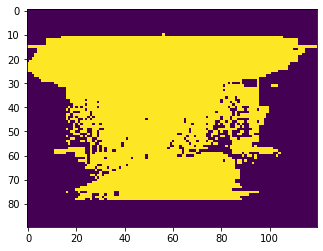

In [55]:
img = cv2.imread("thumbnail/train/image_00009.jpeg")
hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
print(hls[..., 1].mean(), hls[..., 1].mean())
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img2 = cv2.threshold(gray,15, 255, cv2.THRESH_BINARY)[1]
print(gray[0,0], img2[0,0])
print(gray.shape, img2.shape)
plt.imshow(img2)

In [92]:
def get_satu(x):
    img = cv2.imread(x)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l = img[..., 1].mean()
    return l

def get_light(x):
    img = cv2.imread(x)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    s = img[..., 2].mean()
    
    return s

In [93]:
def get_saturation_and_lightness(df):
    df["saturation"] = df["thumbnail_path"].apply(lambda x : get_satu(x))
    df["lightness"] = df["thumbnail_path"].apply(lambda x : get_light(x))
    
    return df

# Run preprocessing

In [94]:
def preprocessing(df, df_test, methods):
    for method in methods:
        df = method(df)
        df_test = method(df_test)
    
    return df, df_test

In [85]:
def original(df):
    return df

In [87]:
ever = [fillNan, logarize, boolToInt, getPublishedAtDetail, getColletction_dateDetail]
results = []
for x in [original, likes_dislikes_ratio,
     comments_likes_ratio,
     comments_dislikes_ratio,
     likes_comments_disabled,
     dislikes_commentes_diabled,
     comments_ratings_diabled,
     getTagDetail,
     delta,
     getDescriptionDetail,
     lenTitle,
     confirmJapanese,
     countEnglish,
     getMusic,
     confirmOfficial,
     getCM,
     get_dummies_from_category,
     get_num_channel_over_100,
     judge_categoryId_over_30,
     get_saturation_and_lightness
    ]:
    train = pd.read_csv("data/train_data.csv")
    test = pd.read_csv("data/test_data.csv")
    train_path = Path("thumbnail/train")
    test_path = Path("thumbnail/test")

    train["thumbnail_path"] = [str(x) for x in sorted(train_path.glob("image*"))]
    test["thumbnail_path"] = [str(x) for x in sorted(test_path.glob("image*"))]
    temp = ever + [x]
    train, test = preprocessing(
        train, 
        test, 
        temp
    )
    idx = []
    for column in train.columns:
        if column in ["y", "likes", "dislikes", "comment_count", 
                      "delta", "channelId", "video_id", "title",
                      "description", "thumbnail_link", 
                      "tags", "publishedAt", "collection_date", "id", "channelTitle", "thumbnail_path"]:#, "categoryId"]:
            continue
        idx.append(column)

    X = train.loc[:, idx].values
    Y = np.log(train.loc[:, "y"]).values
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)
    x_train_train, x_train_test, y_train_train, y_train_test = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
    
    K = 4

    print("K = ", K)
    kf = KFold(n_splits = K, shuffle=True, random_state=42).split(x_train, y_train)
    gbm = [None] * K
    scores = []
    scores_test = []
    for i, (train_idx, test_idx) in enumerate(kf):
        x_train = X[train_idx]
        y_train = Y[train_idx]
        x_test = X[test_idx]
        y_test = Y[test_idx]

        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_test = lgb.Dataset(x_test, y_test)



        # LightGBM parameters
        params = {
                'task' : 'train',
                'boosting_type' : 'gbdt',
                'objective' : 'regression',
                'metric' : "rmse",
                'num_leaves' : 32,
                'learning_rate' : 0.01,
                #'feature_fraction' : 0.9,
                #'bagging_fraction' : 0.8,
                #'bagging_freq': 5,
                'random_state' : 42


        }

        # train
        gbm[i] = lgb.train(
            params,
            lgb_train,
            num_boost_round=10000,
            valid_sets=lgb_test,
            early_stopping_rounds=100, 
            verbose_eval=10000
        )


        y_pred = gbm[i].predict(x_test, num_iteration=gbm[i].best_iteration)
        y_pred = np.exp(y_pred).astype(int)
        y_pred[y_pred < 0] = 0
        rmsle_test = RMSLE(y_pred, np.exp(y_test))

        scores_test.append(rmsle_test)

    print("Feature : ", x.__name__)
    print("Test RMSLE : {}±{}".format(np.mean(scores_test), np.var(scores_test)))
    results.append((x.__name__, np.mean(scores_test)))
    

K =  4
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[557]	valid_0's rmse: 0.903321
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[545]	valid_0's rmse: 0.964878
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[789]	valid_0's rmse: 0.877797
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[945]	valid_0's rmse: 0.882067
Feature :  original
Test RMSLE : 0.9065605657817009±0.0012224490802946284
K =  4
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[792]	valid_0's rmse: 0.89997
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[507]	valid_0's rmse: 0.964309
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[723]	valid_0's rmse: 0.878854
Training until va

In [90]:
sorted(results, key=lambda x : x[1])

[('countEnglish', 0.883846538792093),
 ('getTagDetail', 0.884406064595451),
 ('get_dummies_from_category', 0.901429513332205),
 ('getDescriptionDetail', 0.9014587459488523),
 ('confirmOfficial', 0.901515943413413),
 ('get_saturation_and_lightness', 0.9019895179133987),
 ('getMusic', 0.9021124548475746),
 ('delta', 0.9043233688070584),
 ('lenTitle', 0.9051386382585773),
 ('comments_likes_ratio', 0.9054168091599561),
 ('get_num_channel_over_100', 0.9055907799126803),
 ('comments_dislikes_ratio', 0.9056850350866388),
 ('comments_ratings_diabled', 0.9059345212225386),
 ('original', 0.9065605657817009),
 ('confirmJapanese', 0.9065605657817009),
 ('judge_categoryId_over_30', 0.9065605657817009),
 ('likes_comments_disabled', 0.9070104187566351),
 ('dislikes_commentes_diabled', 0.9070104187566351),
 ('getCM', 0.9070962745235941),
 ('likes_dislikes_ratio', 0.9073001982773835)]

In [133]:
train = pd.read_csv("data/train_data.csv")
test = pd.read_csv("data/test_data.csv")
train["thumbnail_path"] = [str(x) for x in sorted(train_path.glob("image*"))]
test["thumbnail_path"] = [str(x) for x in sorted(test_path.glob("image*"))]
train.shape

(19720, 18)

In [134]:
train, test = preprocessing(
    train, 
    test, 
    [fillNan, 
     logarize, 
     boolToInt,
     likes_dislikes_ratio,
     comments_likes_ratio,
     comments_dislikes_ratio,
     likes_comments_disabled,
     dislikes_commentes_diabled,
     comments_ratings_diabled,
     getTagDetail,
     getPublishedAtDetail,
     getColletction_dateDetail,
     delta,
     getDescriptionDetail,
     lenTitle,
     confirmJapanese,
     countEnglish,
     getMusic,
     confirmOfficial,
     getCM,
     #get_dummies_from_category,
     get_num_channel_over_100,
     #judge_categoryId_over_30
     get_saturation_and_lightness
    ]
)



Category ID, カテゴリへの関連付け  
1 : Film and animation 1   
2 : Autos and vehicles 1   
10 : Music 1   
15 : Pets and animals 1   
17 : Sports 1   
19 : Travel and events 1   
20 : Gaming 1   
22 : People and blogs 1   
23 : Comedy 1   
24 : Entertainment 1   
25 : News and politics 1   
26 : Howto and style 1   
27 : Education 1   
28 : Science and technology 1   
29 : ?  
30 : Movies 0   
43 : Shows（番組）0   
44 : Trailers（予告編）0   

Movies, entertaiments 1 - 30 - 43 - 44 - (10) - (20) -(24)  
Vhehicles 2  
Sounds 10  
Animals 15  
Sports 17  
Travels 19  
Games 20  
Blogs : 22 - 26  
Politics : 25  
Howto : 26  
Study : (26) - 27 - 28  


# Prepare data

In [135]:
idx = []
for column in train.columns:
    if column in ["y", "likes", "dislikes", "comment_count", 
                  "delta", "channelId", "video_id", "title",
                  "description", "thumbnail_link", 
                  "tags", "publishedAt", "collection_date", "id", "channelTitle", "thumbnail_path"]:#, "categoryId"]:
        continue
    idx.append(column)
print("idx : ", idx)

idx :  ['categoryId', 'comments_disabled', 'ratings_disabled', 'log_likes', 'log_dislikes', 'log_comment_count', 'likes_dislikes_ratio', 'comments_likes_ratio', 'comments_dislikes_ratio', 'likes_comments_disabled', 'dislikes_comments_disabled', 'comments_ratings_diabled', 'num_tags', 'length_tags', 'tags_point', 'count_en_tag', 'count_ja_tag', 'publishedAt_year', 'publishedAt_month', 'publishedAt_day', 'publishedAt_hour', 'publishedAt_minute', 'publishedAt_second', 'publishedAt_dayofweek', 'collection_date_year', 'collection_date_month', 'collection_date_day', 'logdelta', 'published_delta', 'collection_delta', 'is_http_in_dis', 'len_description', 'is_insta_in_dis', 'is_twitter_in_dis', 'len_title', 'ja_title', 'ja_tags', 'ja_description', 'en_title', 'en_tags', 'en_description', 'music_title', 'music_tags', 'music_description', 'is_off', 'is_off_channell', 'is_off_ja', 'is_off_channell_ja', 'cm_title', 'cm_tags', 'cm_description', 'ANNnewsCH', 'Khan Academy', 'TED', 'UNIVERSAL MUSIC JA

In [136]:
X = train.loc[:, idx].values
Y = np.log(train.loc[:, "y"]).values

print("X shape : ", X.shape)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)
x_train_train, x_train_test, y_train_train, y_train_test = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

X shape :  (19720, 59)



# Build a model and validation

In [137]:
K = 4

print("K = ", K)
kf = KFold(n_splits = K, shuffle=True, random_state=42).split(x_train, y_train)
gbm = [None] * K
scores = []
scores_test = []
for i, (train_idx, test_idx) in enumerate(kf):
    x_train = X[train_idx]
    y_train = Y[train_idx]
    x_test = X[test_idx]
    y_test = Y[test_idx]
   
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_test = lgb.Dataset(x_test, y_test)



    # LightGBM parameters
    params = {
            'task' : 'train',
            'boosting_type' : 'gbdt',
            'objective' : 'regression',
            'metric' : "rmse",
            'num_leaves' : 32,
            'learning_rate' : 0.01,
            #'feature_fraction' : 0.9,
            #'bagging_fraction' : 0.8,
            #'bagging_freq': 5,
            'random_state' : 42


    }

    # train
    gbm[i] = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,
        valid_sets=lgb_test,
        early_stopping_rounds=100, 
        verbose_eval=10000
    )


    y_pred = gbm[i].predict(x_test, num_iteration=gbm[i].best_iteration)
    y_pred = np.exp(y_pred).astype(int)
    y_pred[y_pred < 0] = 0
    rmsle_test = RMSLE(y_pred, np.exp(y_test))

    scores_test.append(rmsle_test)


print("Test RMSLE : {}±{}".format(np.mean(scores_test), np.var(scores_test)))



K =  4
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1429]	valid_0's rmse: 0.853877
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[777]	valid_0's rmse: 0.936109
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[846]	valid_0's rmse: 0.852569
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1249]	valid_0's rmse: 0.830073
Test RMSLE : 0.8677066011965021±0.0016375868903321916


Provisual best score : 0.870526493774021±0.0016966648056599104

# Let model learn with Kfold and predict test data.

In [138]:
K = 11

print("K = ", K)
kf = KFold(n_splits = K, shuffle=True, random_state=42).split(X, Y)
gbm = [None] * K
scores = []
scores_test = []
for i, (train_idx, test_idx) in enumerate(kf):
    x_train = X[train_idx]
    y_train = Y[train_idx]
    x_test = X[test_idx]
    y_test = Y[test_idx]
   
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_test = lgb.Dataset(x_test, y_test)



    # LightGBM parameters
    params = {
            'task' : 'train',
            'boosting_type' : 'gbdt',
            'objective' : 'regression',
            'metric' : "rmse",
            'num_leaves' : 32,
            'learning_rate' : 0.01,
            #'feature_fraction' : 0.9,
            #'bagging_fraction' : 0.8,
            #'bagging_freq': 5,
            'random_state' : 42


    }

    # train
    gbm[i] = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,
        valid_sets=lgb_test,
        early_stopping_rounds=100, 
        verbose_eval=10000
    )

    y_pred = gbm[i].predict(x_train, num_iteration=gbm[i].best_iteration)
    y_pred = np.exp(y_pred).astype(int)
    y_pred[y_pred < 0] = 0
    rmsle_train = RMSLE(y_pred, np.exp(y_train))
    y_pred = gbm[i].predict(x_test, num_iteration=gbm[i].best_iteration)
    y_pred = np.exp(y_pred).astype(int)
    y_pred[y_pred < 0] = 0
    rmsle_test = RMSLE(y_pred, np.exp(y_test))

    scores.append(rmsle_train)
    scores_test.append(rmsle_test)


print("Training RMSLE :{}±{} ".format(np.mean(scores), np.var(scores)))
print("Test RMSLE : {}±{}".format(np.mean(scores_test), np.var(scores_test)))


K =  11
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2357]	valid_0's rmse: 0.819823
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1743]	valid_0's rmse: 0.840169
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3964]	valid_0's rmse: 0.785365
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1783]	valid_0's rmse: 0.854713
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3241]	valid_0's rmse: 0.785131
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1882]	valid_0's rmse: 0.776847
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3104]	valid_0's rmse: 0.805596
Training until validation scores don't improve for 100 rounds
Early stopping, best iterat

In [139]:
t = test.loc[:, idx].values

In [140]:
K = 11
y_pred = np.array([0.] * len(t))
for x in range(K):
    pred = gbm[x].predict(t, num_iteration=gbm[x].best_iteration)
    pred = np.exp(pred)
    pred[pred < 0] = 0
    y_pred += pred
    

y_pred = (y_pred / K).astype(np.int)

In [141]:
data = np.array([list(range(1, len(y_pred)+1)), y_pred]).T
df_submit = pd.DataFrame(
    data,
    columns=["id", "y"]
)

In [142]:
df_submit.head()

,id,y
0,1,244632
1,2,2800871
2,3,901836
3,4,163040
4,5,259


In [128]:
df_submit.to_csv("submit_10.csv", index=False)